# Temperature Dependence

OpenMC is a bit different than other Monte Carlo codes in how it treats temperature depedence in a few ways. First, as we've seen already, one never has to specify "cross sections suffixes" that appear in codes that use ACE data like MCNP and Serpent. As we'll show here, temperatures can be directly specified on cells or materials. Additionally, OpenMC has the option of using special windowed multipole data that allows it to do on-the-fly Doppler broadening.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import openmc

import sys
sys.path.append('../..')
from inputs import *

For this session, we'll work with a simple pin-cell model.

In [2]:
pincell = PinCellInputSet()

First, let's see what materials have been assigned to cells:

In [3]:
cells = pincell.geometry.get_all_cells()
for cid, cell in cells.items():
    print(cid, cell.fill.name)

10000 Fuel
10001 Cladding
10002 Hot borated water


Now we can assign variables to these cells.

In [4]:
fuel = cells[10000]
clad = cells[10001]
water = cells[10002]

Thus far, no temperatures have been assigned anywhere in the model. There are three ways we can specify temperatures:

- As a global default in `Settings.temperature['default']`.
- As a default for a material in `Material.temperature`.
- Applied to a cell as `Cell.temperature`.

Material temperatures override the global default and cell temperatures override the material defaults. In the absence of any specification, OpenMC assumes that you want room temperature (293.6 K) cross sections.

## `Settings.temperature`

The `Settings.temperature` attribute is a dictionary that takes the following keys:

- `'default'`: global default temperature in Kelvin
- `'method'`: method for handling temperature, either `'nearest'` or `'interpolation'`
- `'tolerance'`: for nearest temperature, how close a temperature can be
- `'multipole'`: Boolean value indicating whether to use multipole data

To use multipole data, we either need to set `Settings.multipoly_library` or the `OPENMC_MULTIPOLE_LIBRARY` environment variable.

## Fuel temperature coefficient

In this example, we'll calculate the fuel temperature coefficient in our pin cell model by iteratively changing the temperature. The fuel has U234, U235, U238, and O16 in it. Our multipoly library does not have data for O16, so we'll set a very high tolerance for temperature searches (effectively assuming the O16 cross section doesn't change).

In [5]:
pincell.settings.temperature = {
    'method': 'nearest',
    'tolerance': 1000.,
    'multipole': True
}
pincell.settings.particles = 10000

In [6]:
temperatures = np.array([300., 500., 800.])
keff = np.zeros_like(temperatures)
keff_std = np.zeros_like(temperatures)

for i, T in enumerate(temperatures):
    # Change temperature of the fuel
    fuel.temperature = T
    
    # Re-export geometry.xml
    pincell.export()
    
    # Run OpenMC and get keff
    openmc.run(output=False)
    sp = openmc.StatePoint('statepoint.{}.h5'.format(pincell.settings.batches))
    keff[i], keff_std[i] = sp.k_combined

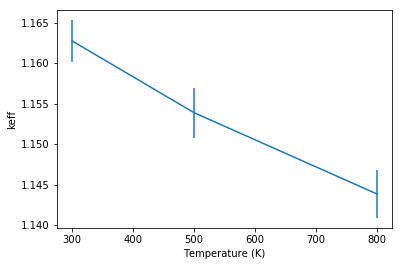

In [7]:
plt.errorbar(temperatures, keff, 2*keff_std)
plt.xlabel('Temperature (K)')
plt.ylabel('keff')

## Tally Derivatives

A recent feature added to OpenMC is the ability to apply a material perturbation derivative to a tally. Let's try using this to estimate the derivative of the neutron production cross section of the fuel material with respect to temperature.

In [8]:
# Reset the fuel temperature
fuel.temperature = 300.0

# Create a tally with a derivative
t = openmc.Tally()
t.derivative = openmc.TallyDerivative(1, 'temperature', fuel.fill.id)
t.scores = ['nu-fission']

# Re-export our input files
pincell.tallies.append(t)
pincell.export()

In [9]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [10]:
!cat tallies.out


 ==========================>     TALLY 10000     <==========================

 Temperature derivative  Material 10000      
 Total Material
   Nu-Fission Rate                      -4.57169E-05   +/- 1.97621E-06


Let's compare this to the fuel temperature coefficient that we got from before.

In [11]:
dkdT = np.diff(keff)/np.diff(temperatures)
dkdT

array([ -4.42385029e-05,  -3.34087630e-05])